# Use NMF with Peak Shifting Learned by Gradient Decent
In our XRD measurements, the peaks shift due to temperature.
We are going to try to allow the learned components by NMF shift between different patterns
This notebook tests out our implementation written in Keras

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from multimodal.keras import SingleModalFactorization, run_training
from keras.regularizers import L1L2
from keras.models import Sequential
from keras.layers import InputLayer
from keras import backend as K
import numpy as np

Using TensorFlow backend.


## Some Some Synthetic Data
We want a dataset with two peaks, one that moves slightly with temperature and another that gradually increases in contribution with temperature

In [2]:
x = np.linspace(0, 10, 64)

In [3]:
def gaussian(x, b):
    return np.exp(-1 * np.power((x - b) * 2, 2))

In [4]:
signal = np.vstack([
    gaussian(x, 2+i) + i * gaussian(x, 8) for i in np.linspace(0, 1, 32)
])

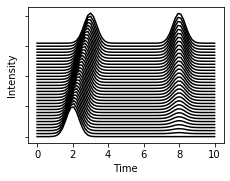

In [5]:
fig, ax = plt.subplots()

for i, row in enumerate(signal):
    ax.plot(x, row + i / 10, 'k-')

ax.set_yticklabels([])
ax.set_ylabel('Intensity')
ax.set_xlabel('Time')
fig.set_size_inches(3.5, 2.5)

As desired, we have a moving peak with constant contribution and a stationary peak that shows up in later rows

## Do Standard NMF
For a benchmark and to make sure I implemented it correctly in Keras

In [6]:
nmf = Sequential([InputLayer(batch_input_shape=signal.shape, name='signal'),
                  SingleModalFactorization(name='factorization', fit_shift=False)])
nmf.compile('adam', 'mean_squared_error')
nmf.summary()





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
factorization (SingleModalFa (32, 64)                  192       
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________


In [7]:
%%time
history = run_training(nmf, signal, 1000, early_stopping_patience=100)



Wall time: 3.6 s


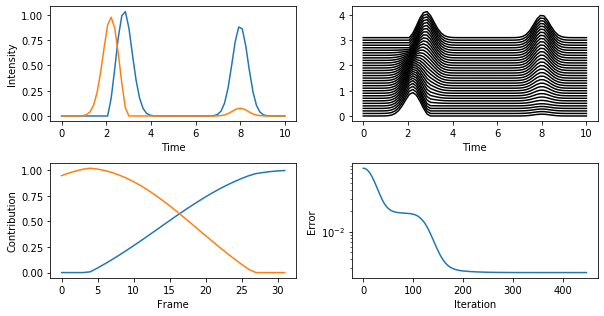

In [8]:
fig, axs = plt.subplots(2, 2)
axs = axs.flatten()

nmf_layer = nmf.get_layer('factorization')
components = nmf_layer.get_components()
weights = nmf_layer.get_contributions()

# Plot the components
for comp in nmf_layer.get_components():
    axs[0].plot(x, comp)
axs[0].set_ylabel('Intensity')
    
# Plot the reconstruction
signal_recon = nmf.predict_on_batch(signal)
for i, row in enumerate(signal_recon):
    axs[1].plot(x, row + i / 10, 'k-')
    
for ax in axs[:2]:
    ax.set_xlabel('Time')
    
for w in weights.T:
    axs[2].plot(w)
axs[2].set_xlabel('Frame')
axs[2].set_ylabel('Contribution')

axs[3].semilogy(history['epoch'], history['loss'])
axs[3].set_xlabel('Iteration')
axs[3].set_ylabel('Error')

fig.set_size_inches(8.5, 4.5)
fig.tight_layout()

*Finding*: Consistant with NMF using scikit-learn. Trains very quickly

## NMF with Peak Shifting
Add in the ability for the "components" to shift over time

In [9]:
nmf = Sequential([InputLayer(batch_input_shape=signal.shape, name='signal'),
                  SingleModalFactorization(name='factorization', fit_shift=True)])
nmf.compile('adam', 'mean_squared_error')
nmf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
factorization (SingleModalFa (32, 64)                  256       
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [10]:
%%time
history = run_training(nmf, signal, 10000, early_stopping_patience=100,
                       early_stopping_tolerance=1e-7)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Wall time: 1min 25s


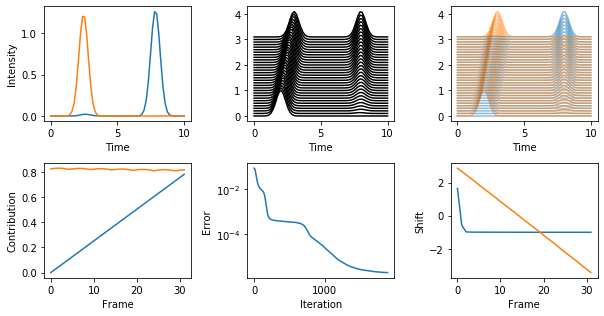

In [11]:
fig, axs = plt.subplots(2, 3)
axs = axs.flatten()

# Get the learned representation
nmf_layer = nmf.get_layer('factorization')
components = nmf_layer.get_components()
weights = nmf_layer.get_contributions()
shifted_components = K.get_value(nmf_layer.shifted_contributions)
shift_values = K.get_value(nmf_layer.shift)

# Plot the components
for comp in nmf_layer.get_components():
    axs[0].plot(x, comp)
axs[0].set_ylabel('Intensity')
    
# Plot the reconstruction
signal_recon = nmf.predict_on_batch(signal)
for i, row in enumerate(signal_recon):
    axs[1].plot(x, row + i / 10, 'k-')
    
# Plot the reconstruction, broken down into components
for comp, c in zip(shifted_components, ['C0', 'C1']):
    for i, row in enumerate(comp):
        axs[2].plot(x, row + i / 10, c, zorder=i, alpha=0.5)
    
for ax in axs[:3]:
    ax.set_xlabel('Time')
    
for w in weights.T:
    axs[3].plot(w)
axs[3].set_xlabel('Frame')
axs[3].set_ylabel('Contribution')

axs[4].semilogy(history['epoch'], history['loss'])
axs[4].set_xlabel('Iteration')
axs[4].set_ylabel('Error')

for shift in shift_values.T:
    axs[5].plot(shift)
axs[5].set_xlabel('Frame')
axs[5].set_ylabel('Shift')

fig.set_size_inches(8.5, 4.5)
fig.tight_layout()

*Finding*: We correctly get that there are two components and that one moves, and the other grows. We do see that there is an unphysical change in the shifts for the data and a periodic wobble in the contributions.

## NMF with Regualization and Shifting
Apply regularization to the NMF fitting.

In [12]:
nmf = Sequential([InputLayer(batch_input_shape=signal.shape, name='signal'),
                  SingleModalFactorization(name='factorization', fit_shift=True,
                                          regularizer=L1L2(1e-6))])
nmf.compile('adam', 'mean_squared_error')
nmf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
factorization (SingleModalFa (32, 64)                  256       
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [13]:
%%time
history = run_training(nmf, signal, 10000, early_stopping_patience=100,
                       early_stopping_tolerance=1e-7)

Wall time: 2min 4s


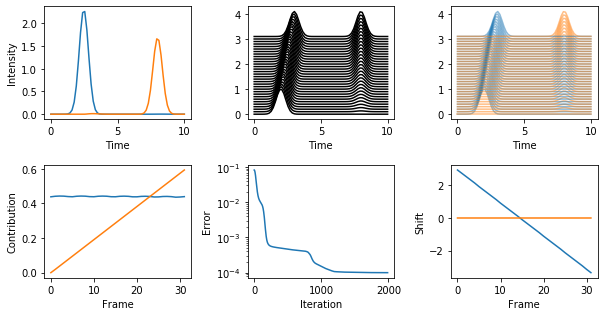

In [14]:
fig, axs = plt.subplots(2, 3)
axs = axs.flatten()

# Get the learned representation
nmf_layer = nmf.get_layer('factorization')
components = nmf_layer.get_components()
weights = nmf_layer.get_contributions()
shifted_components = K.get_value(nmf_layer.shifted_contributions)
shift_values = K.get_value(nmf_layer.shift)

# Plot the components
for comp in nmf_layer.get_components():
    axs[0].plot(x, comp)
axs[0].set_ylabel('Intensity')
    
# Plot the reconstruction
signal_recon = nmf.predict_on_batch(signal)
for i, row in enumerate(signal_recon):
    axs[1].plot(x, row + i / 10, 'k-')
    
# Plot the reconstruction, broken down into components
for comp, c in zip(shifted_components, ['C0', 'C1']):
    for i, row in enumerate(comp):
        axs[2].plot(x, row + i / 10, c, zorder=i, alpha=0.5)
    
for ax in axs[:3]:
    ax.set_xlabel('Time')
    
for w in weights.T:
    axs[3].plot(w)
axs[3].set_xlabel('Frame')
axs[3].set_ylabel('Contribution')

axs[4].semilogy(history['epoch'], history['loss'])
axs[4].set_xlabel('Iteration')
axs[4].set_ylabel('Error')

for shift in shift_values.T:
    axs[5].plot(shift)
axs[5].set_xlabel('Frame')
axs[5].set_ylabel('Shift')

fig.set_size_inches(8.5, 4.5)
fig.tight_layout()

*Finding*: A slight amount of regularization pushes away some of the jitter in the shifting peak, and makes the shift values have an average of zero. 